In [1]:
import IPython.display as ipd
import sys
sys.path.append('C:\\Users\\quanz\\Documents\\UM\\Projects\\GLX_Project\\DNN\\kelletal2018-master\\kelletal2018-master\\network')
from branched_network_class import branched_network
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import scipy.io.wavfile as wav
import matplotlib as plt 
%pylab inline

Instructions for updating:
non-resource variables are not supported in the long term
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\quanz\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# import the following to run demo_from_wav()
import os
new_directory = ('C:/Users/quanz/Documents/UM/Projects/GLX_Project/DNN/kelletal2018-master/kelletal2018-master')
os.chdir(new_directory)
#sys.path.append(new_directory)
from pycochleagram import cochleagram as cgram 
from PIL import Image

C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [3]:
def generate_cochleagram(wav_f, sr, title):
    # Define parameters
    n, sampling_rate = 50, 16000
    low_lim, hi_lim = 20, 8000
    sample_factor, pad_factor, downsample = 4, 2, 200
    nonlinearity, fft_mode, ret_mode = 'power', 'auto', 'envs'
    strict = True

    # Create cochleagram
    c_gram = cgram.cochleagram(wav_f, sr, n, low_lim, hi_lim, 
                               sample_factor, pad_factor, downsample,
                               nonlinearity, fft_mode, ret_mode, strict)
    
    # Debugging statements
    #print("Cochleagram shape:", c_gram.shape)
    #print("Min value in cochleagram:", np.min(c_gram))
    #print("Max value in cochleagram:", np.max(c_gram))

    # Avoiding log10 issues
    # c_gram[c_gram <= 0] = 1e-10  # Set non-positive values to a small positive number

    # Rescale to [0, 255]
    # c_gram_rescaled = 255 * (1 - ((np.max(c_gram) - c_gram) / np.ptp(c_gram)))

    # Check the shape of c_gram_rescaled
    # print("Shape of c_gram_rescaled:", c_gram_rescaled.shape)

     # rescale to [0,255]
    c_gram_rescaled =  255*(1-((np.max(c_gram)-c_gram)/np.ptp(c_gram)))
    
    # reshape to (256,256)
    c_gram_reshape_1 = np.reshape(c_gram_rescaled, (211,400))
    c_gram_reshape_2 = resample(c_gram_reshape_1,(256,256))
    
    # plot_cochleagram(c_gram_reshape_2, title)

    # prepare to run through network -- i.e., flatten it
    c_gram_flatten = np.reshape(c_gram_reshape_2, (1, 256*256)) 
    
    return c_gram_flatten

In [4]:
def resample(example, new_size):
    im = Image.fromarray(example)
    resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
    return np.array(resized_image)

In [5]:
# Codes looking into conv1 layer
import numpy as np
from scipy.io import wavfile as wav
import librosa
import pandas as pd

from tqdm import tqdm
from branched_network_class import branched_network
net_object = branched_network()  # Initialize your network model


# Load the keys for the model outputs
# word_key = np.load('./demo_stim/logits_to_word_key.npy')  # Speech labels
# music_key = np.load('./demo_stim/logits_to_genre_key.npy')  # Music genre labels

# define the folder where we save all the segments we want to pass into DNN
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

all_conv1_activations = []
# make a matrix to save the activation:
    
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))
        c_gram = generate_cochleagram(wav_f, sr, filename)

        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Shape: (1, 86, 86, 96)
        conv1_activation = activations['conv1']  # Shape: (1, 86, 86, 96)

        all_conv1_activations.append(conv1_activation[0])

# Stack all activations along the time axis
final_conv1_activations = np.concatenate(all_conv1_activations, axis=0)  # Shape: (total_time_steps, 86, 96)

# Verify the shape of the final activation array
print(f"Final conv1 activation shape: {final_conv1_activations.shape}")


# Flatten the spatial dimensions (86x96) for easier CSV storage
flattened_activations = final_conv1_activations.reshape(final_conv1_activations.shape[0], -1)

# Create a DataFrame for the flattened activations
df = pd.DataFrame(flattened_activations, columns=[f'Unit_{i}' for i in range(flattened_activations.shape[1])])

# Define the output CSV file path
output_csv = 'final_conv1_activations.csv'

# Save the activations to a CSV file
df.to_csv(output_csv, index=False)

print(f"All conv1 activations saved successfully to {output_csv}.")
    
    

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\pycochleagram\cochleagram.py:137: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)
C:\Users\quanz\AppData\Local\Temp\ipykernel_39992\1703858689.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.18s/it]


Final conv1 activation shape: (860, 86, 96)
All conv1 activations saved successfully to final_conv1_activations.csv.


In [9]:
# Codes looking into conv2 layer
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv2 activations
all_conv2_activations = []

# Process each audio file and extract activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))
        
        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv2 activations
        conv2_activation = activations['conv2']  # Assuming 'conv2' is the key
        print(f"{filename}: Conv2 activation shape {conv2_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv2_activations.append(conv2_activation[0])

# Stack all Conv2 activations along the time axis
final_conv2_activations = np.concatenate(all_conv2_activations, axis=0)

# Verify the shape of the final Conv2 activations array
print(f"Final Conv2 activation shape: {final_conv2_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv2_activations = final_conv2_activations.reshape(
    final_conv2_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv2 activations
df_conv2 = pd.DataFrame(
    flattened_conv2_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv2_activations.shape[1])]
)

# Define the output CSV file path for Conv2 activations
output_csv_conv2 = 'final_conv2_activations.csv'

# Save the Conv2 activations to a CSV file
df_conv2.to_csv(output_csv_conv2, index=False)

print(f"All Conv2 activations saved successfully to {output_csv_conv2}.")

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\pycochleagram\cochleagram.py:137: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)
C:\Users\quanz\AppData\Local\Temp\ipykernel_39992\1703858689.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
 18%|███████████████                                                                    | 2/11 [00:08<00:36,  4.09s/it]

Violin_segment_1.wav: Conv2 activation shape (1, 22, 22, 256)


 27%|██████████████████████▋                                                            | 3/11 [00:08<00:21,  2.66s/it]

Violin_segment_10.wav: Conv2 activation shape (1, 22, 22, 256)


 36%|██████████████████████████████▏                                                    | 4/11 [00:09<00:13,  1.92s/it]

Violin_segment_2.wav: Conv2 activation shape (1, 22, 22, 256)


 45%|█████████████████████████████████████▋                                             | 5/11 [00:10<00:08,  1.49s/it]

Violin_segment_3.wav: Conv2 activation shape (1, 22, 22, 256)


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:10<00:06,  1.22s/it]

Violin_segment_4.wav: Conv2 activation shape (1, 22, 22, 256)


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:11<00:04,  1.04s/it]

Violin_segment_5.wav: Conv2 activation shape (1, 22, 22, 256)


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:12<00:02,  1.08it/s]

Violin_segment_6.wav: Conv2 activation shape (1, 22, 22, 256)


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:12<00:01,  1.17it/s]

Violin_segment_7.wav: Conv2 activation shape (1, 22, 22, 256)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:13<00:00,  1.26it/s]

Violin_segment_8.wav: Conv2 activation shape (1, 22, 22, 256)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.30s/it]

Violin_segment_9.wav: Conv2 activation shape (1, 22, 22, 256)
Final Conv2 activation shape: (220, 22, 256)


All Conv2 activations saved successfully to final_conv2_activations.csv.


In [11]:
# codes to look into conv3
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv3 activations
all_conv3_activations = []

# Process each audio file and extract Conv3 activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))

        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv3 activations
        conv3_activation = activations['conv3']  # Assuming 'conv3' is the correct key
        print(f"{filename}: Conv3 activation shape {conv3_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv3_activations.append(conv3_activation[0])

# Stack all Conv3 activations along the time axis
final_conv3_activations = np.concatenate(all_conv3_activations, axis=0)

# Verify the shape of the final Conv3 activations array
print(f"Final Conv3 activation shape: {final_conv3_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv3_activations = final_conv3_activations.reshape(
    final_conv3_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv3 activations
df_conv3 = pd.DataFrame(
    flattened_conv3_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv3_activations.shape[1])]
)

# Define the output CSV file path for Conv3 activations
output_csv_conv3 = 'final_conv3_activations.csv'

# Save the Conv3 activations to a CSV file
df_conv3.to_csv(output_csv_conv3, index=False)

print(f"All Conv3 activations saved successfully to {output_csv_conv3}.")

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\pycochleagram\cochleagram.py:137: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)
C:\Users\quanz\AppData\Local\Temp\ipykernel_39992\1703858689.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
 18%|███████████████                                                                    | 2/11 [00:09<00:42,  4.73s/it]

Violin_segment_1.wav: Conv3 activation shape (1, 11, 11, 512)


 27%|██████████████████████▋                                                            | 3/11 [00:10<00:24,  3.03s/it]

Violin_segment_10.wav: Conv3 activation shape (1, 11, 11, 512)


 36%|██████████████████████████████▏                                                    | 4/11 [00:10<00:14,  2.14s/it]

Violin_segment_2.wav: Conv3 activation shape (1, 11, 11, 512)


 45%|█████████████████████████████████████▋                                             | 5/11 [00:11<00:09,  1.63s/it]

Violin_segment_3.wav: Conv3 activation shape (1, 11, 11, 512)


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:12<00:06,  1.31s/it]

Violin_segment_4.wav: Conv3 activation shape (1, 11, 11, 512)


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:12<00:04,  1.11s/it]

Violin_segment_5.wav: Conv3 activation shape (1, 11, 11, 512)


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:13<00:02,  1.03it/s]

Violin_segment_6.wav: Conv3 activation shape (1, 11, 11, 512)


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:14<00:01,  1.13it/s]

Violin_segment_7.wav: Conv3 activation shape (1, 11, 11, 512)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:14<00:00,  1.24it/s]

Violin_segment_8.wav: Conv3 activation shape (1, 11, 11, 512)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.40s/it]

Violin_segment_9.wav: Conv3 activation shape (1, 11, 11, 512)
Final Conv3 activation shape: (110, 11, 512)


All Conv3 activations saved successfully to final_conv3_activations.csv.


In [ ]:
# codes that look into con4_W
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv4_W activations
all_conv4_w_activations = []

# Process each audio file and extract Conv4_W activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))

        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv4_W activations
        conv4_w_activation = activations['conv4_W']  # Assuming 'conv4_W' is the correct key
        print(f"{filename}: Conv4_W activation shape {conv4_w_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv4_w_activations.append(conv4_w_activation[0])

# Stack all Conv4_W activations along the time axis
final_conv4_w_activations = np.concatenate(all_conv4_w_activations, axis=0)

# Verify the shape of the final Conv4_W activations array
print(f"Final Conv4_W activation shape: {final_conv4_w_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv4_w_activations = final_conv4_w_activations.reshape(
    final_conv4_w_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv4_W activations
df_conv4_w = pd.DataFrame(
    flattened_conv4_w_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv4_w_activations.shape[1])]
)

# Define the output CSV file path for Conv4_W activations
output_csv_conv4_w = 'final_conv4_W_activations.csv'

# Save the Conv4_W activations to a CSV file
df_conv4_w.to_csv(output_csv_conv4_w, index=False)

print(f"All Conv4_W activations saved successfully to {output_csv_conv4_w}.")


In [ ]:
# codes look into conv4_G
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv4_G activations
all_conv4_g_activations = []

# Process each audio file and extract Conv4_G activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))

        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv4_G activations
        conv4_g_activation = activations['conv4_G']  # Assuming 'conv4_G' is the correct key
        print(f"{filename}: Conv4_G activation shape {conv4_g_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv4_g_activations.append(conv4_g_activation[0])

# Stack all Conv4_G activations along the time axis
final_conv4_g_activations = np.concatenate(all_conv4_g_activations, axis=0)

# Verify the shape of the final Conv4_G activations array
print(f"Final Conv4_G activation shape: {final_conv4_g_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv4_g_activations = final_conv4_g_activations.reshape(
    final_conv4_g_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv4_G activations
df_conv4_g = pd.DataFrame(
    flattened_conv4_g_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv4_g_activations.shape[1])]
)

# Define the output CSV file path for Conv4_G activations
output_csv_conv4_g = 'final_conv4_G_activations.csv'

# Save the Conv4_G activations to a CSV file
df_conv4_g.to_csv(output_csv_conv4_g, index=False)

print(f"All Conv4_G activations saved successfully to {output_csv_conv4_g}.")

In [ ]:
# codes to look into conv5_W
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv5_W activations
all_conv5_w_activations = []

# Process each audio file and extract Conv5_W activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))

        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv5_W activations
        conv5_w_activation = activations['conv5_W']  # Assuming 'conv5_W' is the correct key
        print(f"{filename}: Conv5_W activation shape {conv5_w_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv5_w_activations.append(conv5_w_activation[0])

# Stack all Conv5_W activations along the time axis
final_conv5_w_activations = np.concatenate(all_conv5_w_activations, axis=0)

# Verify the shape of the final Conv5_W activations array
print(f"Final Conv5_W activation shape: {final_conv5_w_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv5_w_activations = final_conv5_w_activations.reshape(
    final_conv5_w_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv5_W activations
df_conv5_w = pd.DataFrame(
    flattened_conv5_w_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv5_w_activations.shape[1])]
)

# Define the output CSV file path for Conv5_W activations
output_csv_conv5_w = 'final_conv5_W_activations.csv'

# Save the Conv5_W activations to a CSV file
df_conv5_w.to_csv(output_csv_conv5_w, index=False)

print(f"All Conv5_W activations saved successfully to {output_csv_conv5_w}.")

In [ ]:
# codes look into conv5_G
import os
import numpy as np
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from branched_network_class import branched_network

# Initialize your network model
net_object = branched_network()

# Define the folder where the audio files are located
audio_folder = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\MiND_Stimili\Demo'

# List to store Conv5_G activations
all_conv5_g_activations = []

# Process each audio file and extract Conv5_G activations
for filename in tqdm(os.listdir(audio_folder)):
    if filename.endswith('.wav'):
        # Read the audio file
        sr, wav_f = wav.read(os.path.join(audio_folder, filename))

        # Generate cochleagram from the audio file
        c_gram = generate_cochleagram(wav_f, sr, filename)

        # Get activations from the DNN model
        input_data = c_gram
        activations = net_object.get_activations(input_data)  # Activations dictionary

        # Extract Conv5_G activations
        conv5_g_activation = activations['conv5_G']  # Assuming 'conv5_G' is the correct key
        print(f"{filename}: Conv5_G activation shape {conv5_g_activation.shape}")

        # Store the activation (drop batch dimension)
        all_conv5_g_activations.append(conv5_g_activation[0])

# Stack all Conv5_G activations along the time axis
final_conv5_g_activations = np.concatenate(all_conv5_g_activations, axis=0)

# Verify the shape of the final Conv5_G activations array
print(f"Final Conv5_G activation shape: {final_conv5_g_activations.shape}")

# Flatten the spatial dimensions for CSV storage
flattened_conv5_g_activations = final_conv5_g_activations.reshape(
    final_conv5_g_activations.shape[0], -1
)

# Create a DataFrame for the flattened Conv5_G activations
df_conv5_g = pd.DataFrame(
    flattened_conv5_g_activations, 
    columns=[f'Unit_{i}' for i in range(flattened_conv5_g_activations.shape[1])]
)

# Define the output CSV file path for Conv5_G activations
output_csv_conv5_g = 'final_conv5_G_activations.csv'

# Save the Conv5_G activations to a CSV file
df_conv5_g.to_csv(output_csv_conv5_g, index=False)

print(f"All Conv5_G activations saved successfully to {output_csv_conv5_g}.")

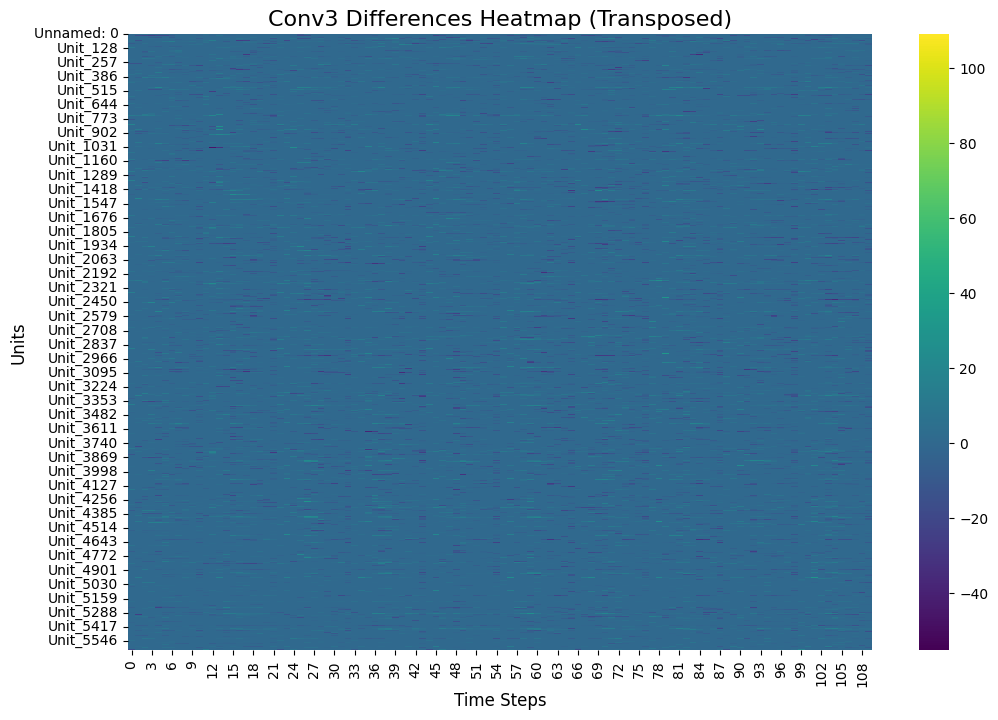

In [18]:
# Now I want to see the heatmap of the activation with rows = units, coumn = times.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Load the CSV into a DataFrame
df = pd.read_csv('contrast.csv')
# df = pd.read_csv('differences.csv')

# Transpose the DataFrame to switch rows and columns
df_transposed = df.T  # Now units will be on the y-axis, and time steps on the x-axis

# Create the heatmap with the transposed data
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(df_transposed, cmap='viridis', cbar=True)

# Add labels and title
plt.title('Conv3 Differences Heatmap (Transposed)', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Units', fontsize=12)

# Display the heatmap
plt.show()


In [14]:
# this code is to figure if the network is determinstic or not:
import pandas as pd

# Load the two CSV files (ensure the paths are correct)
file1 = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\Activation\Music\violin\final_conv3_activations.csv'
file2 = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\Activation\Speech\Macedomin\final_conv3_activations.csv'

try:
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Ensure the data has the same structure
    if df1.shape != df2.shape:
        print(f"Warning: The CSV files have different shapes: {df1.shape} vs {df2.shape}")

    # Find the differences between the two DataFrames
    comparison_df = df1.compare(df2)

    # Check if there are any differences
    if comparison_df.empty:
        print("No differences found between the two CSV files.")
    else:
        print("Differences found between the two CSV files:")
        print(comparison_df)

        # Optionally save the differences to a CSV file
        comparison_df.to_csv('differences.csv', index=True)
        print("Differences saved to 'differences.csv'.")

except FileNotFoundError as e:
    print(f"Error: {e}. Please check if the files exist and the paths are correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Differences found between the two CSV files:
    Unit_0          Unit_1          Unit_2              Unit_3        \
      self other      self other      self     other      self other   
0      NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
1      NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
2      NaN   NaN  2.934515   0.0       NaN       NaN       NaN   NaN   
3      NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
4      NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
..     ...   ...       ...   ...       ...       ...       ...   ...   
105    NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
106    NaN   NaN       NaN   NaN       NaN       NaN       NaN   NaN   
107    NaN   NaN       NaN   NaN  1.045492  0.000000       NaN   NaN   
108    NaN   NaN       NaN   NaN  1.467391  0.000000       NaN   NaN   
109    NaN   NaN       NaN   NaN  3.970307  8.911544  1.506292   0.0   

       Unit_4     

In [17]:
# this code is to see the contrast
import pandas as pd

# Load the two CSV files
file1 = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\Activation\Music\violin\final_conv3_activations.csv'
file2 = r'C:\Users\quanz\Documents\UM\Projects\GLX_Project\DNN\kelletal2018-master\kelletal2018-master\Activation\Speech\Macedomin\final_conv3_activations.csv'

try:
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Ensure the data has the same structure
    if df1.shape != df2.shape:
        print(f"Warning: The CSV files have different shapes: {df1.shape} vs {df2.shape}")

    # Align columns to ensure they match (if necessary)
    df1, df2 = df1.align(df2, join='inner', axis=1)

    # Calculate the difference between the two DataFrames (df1 - df2)
    difference_df = df1 - df2

    # Find only the rows where there are differences (non-zero values)
    difference_df_nonzero = difference_df[(difference_df != 0).any(axis=1)]

    # Check if there are any differences
    if difference_df_nonzero.empty:
        print("No differences found between the two CSV files.")
    else:
        print("Differences found (CSV1 - CSV2):")
        print(difference_df_nonzero)

        # Optionally save the differences to a CSV file
        difference_df_nonzero.to_csv('contrast.csv', index=True)
        print("Differences saved to 'differences.csv'.")

except FileNotFoundError as e:
    print(f"Error: {e}. Please check if the files exist and the paths are correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Differences found (CSV1 - CSV2):
     Unit_0    Unit_1    Unit_2    Unit_3    Unit_4     Unit_5    Unit_6  \
0       0.0  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
1       0.0  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
2       0.0  2.934515  0.000000  0.000000  0.000000   0.000000  0.000000   
3       0.0  0.000000  0.000000  0.000000  0.000000   4.366063  0.000000   
4       0.0  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
..      ...       ...       ...       ...       ...        ...       ...   
105     0.0  0.000000  0.000000  0.000000  0.000000   5.183104  0.000000   
106     0.0  0.000000  0.000000  0.000000  0.630815   0.000000  0.000000   
107     0.0  0.000000  1.045492  0.000000 -2.919096   0.000000  0.000000   
108     0.0  0.000000  1.467391  0.000000 -6.136538  -2.015948  0.000000   
109     0.0  0.000000 -4.941237  1.506292  0.000000 -11.149999  2.251342   

       Unit_7    Unit_8    Unit_9  ...  Unit_5622  Uni

In [ ]:
net_object = branched_network()
print(type(net_object))

In [ ]:
print(filename)


In [ ]:
sr, wav_f = wav.read(os.path.join(audio_folder, filename))
print(sr)

In [ ]:
import os
print(os.getcwd())

In [ ]:
output_csv = 'all_conv1_activations.csv'
df.to_csv(output_csv, index=False)

In [ ]:
import pandas as pd
print(pd.__version__)
%matplotlib inline